In [9]:
# Setups & imports
import pandas as pd
import numpy as np
import pickle
import os
import matplotlib.pyplot as plt
import seaborn as sns

from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
from catboost import CatBoostClassifier

from sklearn.metrics import (
    confusion_matrix, ConfusionMatrixDisplay, f1_score, precision_score, recall_score,
    roc_auc_score, RocCurveDisplay, accuracy_score
)
from sklearn.base import clone

In [10]:
#configuration

Cohort = "mimic_cohort_NF_30_days"
MIMIC_ICD_File = f"../data/{Cohort}/{Cohort}_icd_codes.csv.gz"
MIMIC_TARGET_File= f"../data/{Cohort}/{Cohort}.csv.gz"
Folds_DIR = f"../data/{Cohort}/cv_folds"

#Remote Kane Embeddings (GitHub URLs pre-computed)
GITHUB_BASE = "https://github.com/kaneplusplus/icd-10-cm-embedding/raw/main/embedding-data/"

Embedding_Files = {
    10: "icd-10-cm-2022-0010.csv.gz",
    50: "icd-10-cm-2022-0050.csv.gz",
    100: "icd-10-cm-2022-0100.csv.gz",
    1000: "icd-10-cm-2022-1000.csv.gz"
}


In [12]:
#pre processing (loading/cleaning/mapping)

def load_mimic_data():
    """load patient data and targets"""
    try:
        df_codes= pd.read_csv(MIMIC_ICD_File)
        df_targets= pd.read_csv(MIMIC_TARGET_File)
    except FileNotFoundError as e:
        raise e
    
    #ID cleaning(remove discrepancies eg: E113/E11.3 by removing .)

    id_col = 'hadm_id'
    df_codes[id_col] = df_codes[id_col].astype(str).str.replace('.0','', regex=False)
    df_targets[id_col] = df_targets[id_col].astype(str).str.replace('.0','', regex=False)
    df_codes['icd_code'] = df_codes['icd_code'].astype(str).str.replace(".", "", regex=False).str.strip()
    #Filter valid IDs(intersection)

    valid_ids = np.intersect1d(df_codes[id_col].unique(), df_targets[id_col].unique())
    df_codes = df_codes[df_codes[id_col].isin(valid_ids)]
    df_targets = df_targets[df_targets[id_col].isin(valid_ids)]

    #Align targets index
    df_targets = df_targets.drop_duplicates(subset=[id_col]).set_index(id_col)
    print(f"data loaded: {len(valid_ids)} valid admissions")
    return df_codes, df_targets

def load_embeddings(filename):
    """load the pre computed embeddings into a dictionary from url"""
    url = f"{GITHUB_BASE}{filename}"
    print(f"loading embeddings from: {url}..")
    try:
        df = pd.read_csv(url, compression='gzip')
    except Exception as e:
        return None, None

    #identify vector columns (all cols except code/desc)

    meta_cols= ['code','desc','description']
    vector_cols=[c for c in df.columns if c not in meta_cols] #identifies all the columns constituting the embedding vector

    embed_dict ={}
    for _, row in df.iterrows():
        #cleaning:strip dots to match mimic format
        clean_code= str(row['code']).replace(".","").strip()
        embed_dict[clean_code]= row[vector_cols].values.astype(np.float32)
    return embed_dict, len(vector_cols)


In [13]:
#Feature Engineering

def get_patient_matrix(df_codes, embed_dict, vector_dim, all_ids):
    """Maps: patient -> list of codes -> list of vectors -> avg vector"""
    #helper to avg vectors
    def average_vectors(codes):
        vectors = [embed_dict[c] for c in codes if c in embed_dict]
        if not vectors:
            return np.zeros(vector_dim)
        return np.mean(vectors, axis=0)
    #Group codes by admission
    group = df_codes.groupby('hadm_id')['icd_code'].apply(list)

    #Reindex to ensure we include patients with no codes as zero vectors
    aligned_groups= group.reindex(all_ids, fill_value=[])

    #Apply mapping
    matrix= np.stack(aligned_groups.apply(average_vectors).values)
    return pd.DataFrame(matrix, index=all_ids)

data loaded: 5308 valid admissions

Testing dimensions:[10, 50, 100, 1000]
Processing dimension: 10
loading embeddings from: https://github.com/kaneplusplus/icd-10-cm-embedding/raw/main/embedding-data/icd-10-cm-2022-0010.csv.gz..
   >XGBoost:Avg AUC = 0.5698
   >RandomForest:Avg AUC = 0.5547
   >CatBoost:Avg AUC = 0.5611
Processing dimension: 50
loading embeddings from: https://github.com/kaneplusplus/icd-10-cm-embedding/raw/main/embedding-data/icd-10-cm-2022-0050.csv.gz..
   >XGBoost:Avg AUC = 0.5499
   >RandomForest:Avg AUC = 0.5779
   >CatBoost:Avg AUC = 0.5625
Processing dimension: 100
loading embeddings from: https://github.com/kaneplusplus/icd-10-cm-embedding/raw/main/embedding-data/icd-10-cm-2022-0100.csv.gz..
   >XGBoost:Avg AUC = 0.5888
   >RandomForest:Avg AUC = 0.5960
   >CatBoost:Avg AUC = 0.5782
Processing dimension: 1000
loading embeddings from: https://github.com/kaneplusplus/icd-10-cm-embedding/raw/main/embedding-data/icd-10-cm-2022-1000.csv.gz..
   >XGBoost:Avg AUC = 0

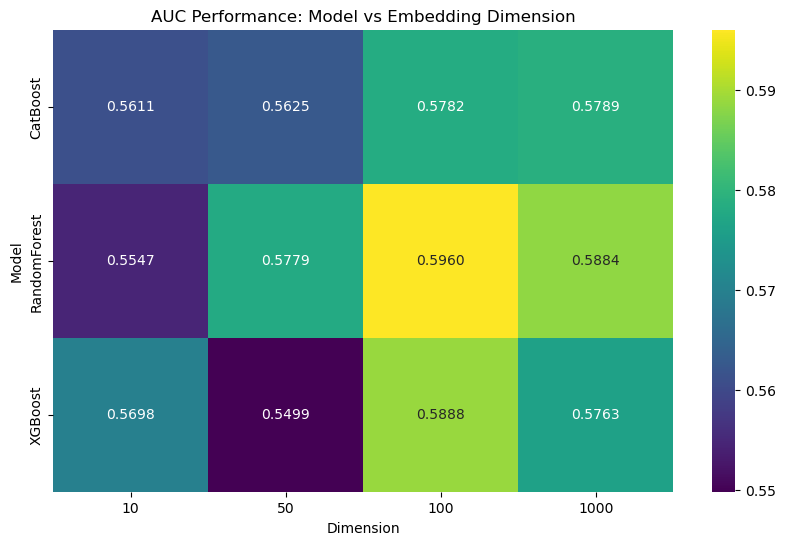


 Best configuration: RandomForest with 100-dim embeddings (AUC:0.5960)


In [14]:
# Main pipeline

if __name__ == "__main__":
    #Load mimic data
    df_codes, df_targets= load_mimic_data()
    all_ids = df_targets.index.values

    #Models_configuration

    base_models={
        "XGBoost": XGBClassifier(n_estimators=200, learning_rate= 0.05, max_depth=6, eval_metric ="logloss", n_jobs=-1, random_state=42),
        "RandomForest": RandomForestClassifier(n_estimators=200, max_depth=10, class_weight="balanced", n_jobs=-1, random_state=42),
        "CatBoost": CatBoostClassifier(iterations=200, learning_rate=0.05, depth=6, verbose=0, allow_writing_files=False, random_state=42)
    }

    #store results for best model
    leaderboard=[]

    print(f"\nTesting dimensions:{list(Embedding_Files.keys())}")

    #Loop: Dimensions->Embeddings->Folds->Models
    for dim, filename in Embedding_Files.items():
        print(f"Processing dimension: {dim}")
        
        #load Embeddings
        embed_dict, actual_dim= load_embeddings(filename)
        if embed_dict is None:
            continue

        #Map patients to vectors
        X_df= get_patient_matrix(df_codes, embed_dict, actual_dim, all_ids)

        #Cross-validation(5-fold)

        dim_results = {name:[] for name in base_models}
        for fold in range(5):
            #load fold
            with open(f"{Folds_DIR}/fold_{fold}.pkl","rb") as f:
                train_split, val_split, test_split = pickle.load(f)
            #ID Cleaning
            train_ids=np.char.replace(np.concatenate([train_split,val_split])[:,1].astype(str),'.0','')
            test_ids=np.char.replace(test_split[:,1].astype(str),'.0','')

            #filtering
            train_ids=[uid for uid in train_ids if uid in df_targets.index]
            test_ids=[uid for uid in test_ids if uid in df_targets.index]

            #split data
            X_train= X_df.loc[train_ids].values
            y_train= df_targets.loc[train_ids, 'label'].values
            X_test= X_df.loc[test_ids].values
            y_test= df_targets.loc[test_ids, 'label'].values

            #Train models
            for name, model in base_models.items():
                clf= clone(model)
                if name in ["XGBoost","CatBoost"]:
                    ratio=float(np.sum(y_train==0))/np.sum(y_train==1)
                    clf.set_params(scale_pos_weight=ratio)
                clf.fit(X_train,y_train)
                y_prob=clf.predict_proba(X_test)[:,1]

                #score
                auc=roc_auc_score(y_test,y_prob)
                dim_results[name].append(auc)
        #store results for this dimension
        for name, aucs in dim_results.items():
            mean_auc= np.mean(aucs)
            print(f"   >{name}:Avg AUC = {mean_auc:.4f}")
            leaderboard.append({
                "Dimension": dim,
                "Model": name,
                "AUC": mean_auc
            })
    #Final report

    results_df=pd.DataFrame(leaderboard).sort_values(by="AUC", ascending=False)
    print(results_df)

    #visualization plot
    plt.figure(figsize=(10,6))
    pivot_table = results_df.pivot(index="Model", columns="Dimension", values="AUC")
    sns.heatmap(pivot_table, annot=True, fmt=".4f", cmap="viridis")
    plt.title("AUC Performance: Model vs Embedding Dimension")
    plt.show()

    best_config = results_df.iloc[0]
    print(f"\n Best configuration: {best_config['Model']} with {best_config['Dimension']}-dim embeddings (AUC:{best_config['AUC']:.4f})")